<a href="https://colab.research.google.com/github/AstrakhantsevaAA/confidence_estimation_resnet/blob/master/confidence_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%writefile requirements.txt
torch
torchvision
tqdm
pillow
matplotlib

Writing requirements.txt


In [0]:
!pip install -r requirements.txt

In [0]:
import numpy as np
from tqdm import tqdm
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import datasets, transforms, models

# from model import resnet 
import resnet


In [0]:
def encode_onehot(labels, n_classes):
    onehot = torch.FloatTensor(labels.size()[0], n_classes)
    labels = labels.data
    if labels.is_cuda:
        onehot = onehot.cuda()
    onehot.zero_()
    onehot.scatter_(1, labels.view(-1, 1), 1)
    return onehot

In [0]:
np.random.seed(0)
torch.cuda.manual_seed(0)
cudnn.deterministic = True
cudnn.benchmark = False

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
filename = 'CIFAR_resnet_cp'

baseline = False
if baseline:
    budget = 0.
else: budget = 0.3

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [8]:
# Image Preprocessing
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])


num_classes = 10
train_dataset = datasets.CIFAR10(root='data/',
                                     train=True,
                                     transform=train_transform,
                                     download=True)

test_dataset = datasets.CIFAR10(root='data/',
                                    train=False,
                                    transform=test_transform,
                                    download=True)




# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [0]:
def test(loader, epoch):
    global best_acc
    test_loss = 0
    cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
    test_loss = []
    correct = []
    probability = []
    confidence = []
    with torch.no_grad():
        for images, labels in loader:
            images = Variable(images, volatile=True).cuda()
            labels = labels.cuda()

            pred, conf = cnn(images)
            pred = F.softmax(pred, dim=-1)
            conf = F.sigmoid(conf).data.view(-1)
            
            loss = prediction_criterion(pred, labels)

            test_loss.append(loss.item()) 
            
            pred_value, pred = torch.max(pred.data, 1)
            correct.extend((pred == labels).cpu().numpy())
            probability.extend(pred_value.cpu().numpy())
            confidence.extend(conf.cpu().numpy())
    test_loss = np.array(test_loss)
    correct = np.array(correct).astype(bool)
    probability = np.array(probability)
    confidence = np.array(confidence)

    val_acc = np.mean(correct)
    val_test_loss = np.mean(test_loss)
    conf_min = np.min(confidence)
    conf_max = np.max(confidence)
    conf_avg = np.mean(confidence)
    

    if val_acc > best_acc:
        print('Saving..')
        state = {
            'net': cnn.state_dict(),
            'acc': val_acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, f'./checkpoint/{filename}.pth')
        best_acc = val_acc

    cnn.train()
    return val_test_loss, val_acc, conf_min, conf_max, conf_avg


In [10]:
print('==> Resuming from checkpoint..')
assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
checkpoint = torch.load('./checkpoint/ckpt.pth')
cnn.load_state_dict(checkpoint['net'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

==> Resuming from checkpoint..


AssertionError: ignored

In [0]:
cnn = resnet.resnet18(num_classes=num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = cnn.to(device)
if device == 'cuda':
    cnn = torch.nn.DataParallel(cnn)

prediction_criterion = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.SGD(cnn.parameters(), lr=1.0e-3,
                      momentum=0.9, weight_decay=5e-4)
scheduler = MultiStepLR(cnn_optimizer, milestones=[60, 120, 160], gamma=0.2)

In [96]:
# Start with a reasonable guess for lambda
lmbda = 0.1

acc_train = []
loss_train = []
acc_test = []
loss_test = []

for epoch in range(start_epoch, start_epoch+200):

    xentropy_loss_avg = 0.
    confidence_loss_avg = 0.
    correct_count = 0.
    total = 0.

    progress_bar = tqdm(train_loader)
    for i, (images, labels) in enumerate(progress_bar):
        progress_bar.set_description('Epoch ' + str(epoch))

        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        labels_onehot = Variable(encode_onehot(labels, num_classes))

        cnn.zero_grad()

        pred_original, confidence = cnn(images)
        
        pred_original = F.softmax(pred_original, dim=-1)
        confidence = torch.sigmoid(confidence)

        # Make sure we don't have any numerical instability
        eps = 1e-12
        pred_original = torch.clamp(pred_original, 0. + eps, 1. - eps)
        confidence = torch.clamp(confidence, 0. + eps, 1. - eps)

        if baseline:
            # Randomly set half of the confidences to 1 (i.e. no hints)
            b = Variable(torch.bernoulli(torch.Tensor(confidence.size()).uniform_(0, 1))).cuda()
            conf = confidence * b + (1 - b)
            
            pred_new = pred_original * conf.expand_as(pred_original) + labels_onehot * (1 - conf.expand_as(labels_onehot))
            pred_new = torch.log(pred_new)
        else:
            pred_new = torch.log(pred_original)

        xentropy_loss = prediction_criterion(pred_new, labels)
        confidence_loss = torch.mean(-torch.log(confidence))

        if baseline:
            total_loss = xentropy_loss
        else:
            total_loss = xentropy_loss + (lmbda * confidence_loss)

            if budget > confidence_loss.item():
                lmbda = lmbda / 1.01
            elif budget <= confidence_loss.item():
                lmbda = lmbda / 0.99

        total_loss.backward()
        cnn_optimizer.step()
        
        xentropy_loss_avg += xentropy_loss.item()
        confidence_loss_avg += confidence_loss.item()

        pred_idx = torch.max(pred_original.data, 1)[1]
        total += labels.size(0)
        correct_count += (pred_idx == labels.data).sum()
        accuracy = correct_count / total

    test_loss, test_acc, conf_min, conf_max, conf_avg = test(test_loader, epoch) 

    acc_train.append(accuracy)
    loss_train.append(xentropy_loss_avg / total)
    
    acc_test.append(test_acc)
    loss_test.append(test_loss)
    
    data = {
        'acc_train': acc_train,
        'loss_train': loss_train,
        'acc_test': acc_test,
        'loss_test': loss_test
    }
    if not os.path.isdir('accs_losses'):
        os.mkdir('accs_losses')
    torch.save(data, f'./accs_losses/accs_losses.pth')

    print(f'\ntrain_acc: {accuracy:.3f}, test_acc: {test_acc:.3f}, conf_min: {conf_min:.3f}, conf_max: {conf_max:.3f}, conf_avg: {conf_avg:.3f}')

    scheduler.step(epoch)

Epoch 0: 100%|██████████| 391/391 [00:23<00:00, 16.74it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  wa

Saving..

train_acc: 0.323, test_acc: 0.422, conf_min: 0.866, conf_max: 1.000, conf_avg: 0.981


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.438, test_acc: 0.483, conf_min: 0.871, conf_max: 1.000, conf_avg: 0.981


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.486, test_acc: 0.528, conf_min: 0.861, conf_max: 1.000, conf_avg: 0.980


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.520, test_acc: 0.545, conf_min: 0.887, conf_max: 1.000, conf_avg: 0.982


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.551, test_acc: 0.577, conf_min: 0.882, conf_max: 1.000, conf_avg: 0.982


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.575, test_acc: 0.598, conf_min: 0.856, conf_max: 1.000, conf_avg: 0.982


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.593, test_acc: 0.609, conf_min: 0.872, conf_max: 1.000, conf_avg: 0.982


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.607, test_acc: 0.610, conf_min: 0.863, conf_max: 1.000, conf_avg: 0.981


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.625, test_acc: 0.647, conf_min: 0.859, conf_max: 1.000, conf_avg: 0.981


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.637, test_acc: 0.649, conf_min: 0.822, conf_max: 1.000, conf_avg: 0.980


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.649, test_acc: 0.654, conf_min: 0.816, conf_max: 1.000, conf_avg: 0.981


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.660, test_acc: 0.664, conf_min: 0.854, conf_max: 1.000, conf_avg: 0.980


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.671, test_acc: 0.666, conf_min: 0.841, conf_max: 1.000, conf_avg: 0.980


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.675, test_acc: 0.679, conf_min: 0.841, conf_max: 1.000, conf_avg: 0.980


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.685, test_acc: 0.691, conf_min: 0.819, conf_max: 1.000, conf_avg: 0.978


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.693, test_acc: 0.679, conf_min: 0.807, conf_max: 1.000, conf_avg: 0.980


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.702, test_acc: 0.701, conf_min: 0.823, conf_max: 1.000, conf_avg: 0.979


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.705, test_acc: 0.697, conf_min: 0.798, conf_max: 1.000, conf_avg: 0.979


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.714, test_acc: 0.710, conf_min: 0.826, conf_max: 1.000, conf_avg: 0.977


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.718, test_acc: 0.706, conf_min: 0.792, conf_max: 1.000, conf_avg: 0.978


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.724, test_acc: 0.717, conf_min: 0.817, conf_max: 1.000, conf_avg: 0.977


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.730, test_acc: 0.712, conf_min: 0.800, conf_max: 1.000, conf_avg: 0.979


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.735, test_acc: 0.723, conf_min: 0.764, conf_max: 1.000, conf_avg: 0.978


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.741, test_acc: 0.731, conf_min: 0.819, conf_max: 1.000, conf_avg: 0.976


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.745, test_acc: 0.730, conf_min: 0.798, conf_max: 1.000, conf_avg: 0.976


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.751, test_acc: 0.739, conf_min: 0.798, conf_max: 1.000, conf_avg: 0.976


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.757, test_acc: 0.736, conf_min: 0.780, conf_max: 1.000, conf_avg: 0.977


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.758, test_acc: 0.735, conf_min: 0.758, conf_max: 1.000, conf_avg: 0.977


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.763, test_acc: 0.743, conf_min: 0.758, conf_max: 1.000, conf_avg: 0.976


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.765, test_acc: 0.742, conf_min: 0.765, conf_max: 1.000, conf_avg: 0.976


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.769, test_acc: 0.735, conf_min: 0.763, conf_max: 1.000, conf_avg: 0.976


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.773, test_acc: 0.746, conf_min: 0.808, conf_max: 1.000, conf_avg: 0.975


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.778, test_acc: 0.746, conf_min: 0.797, conf_max: 1.000, conf_avg: 0.976


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.779, test_acc: 0.753, conf_min: 0.797, conf_max: 1.000, conf_avg: 0.975


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.784, test_acc: 0.756, conf_min: 0.799, conf_max: 1.000, conf_avg: 0.972


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.788, test_acc: 0.760, conf_min: 0.821, conf_max: 1.000, conf_avg: 0.973


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.788, test_acc: 0.756, conf_min: 0.828, conf_max: 1.000, conf_avg: 0.974


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.791, test_acc: 0.761, conf_min: 0.825, conf_max: 1.000, conf_avg: 0.973


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.799, test_acc: 0.759, conf_min: 0.779, conf_max: 1.000, conf_avg: 0.974


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.797, test_acc: 0.752, conf_min: 0.837, conf_max: 1.000, conf_avg: 0.973


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.801, test_acc: 0.760, conf_min: 0.808, conf_max: 1.000, conf_avg: 0.972


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.805, test_acc: 0.765, conf_min: 0.817, conf_max: 1.000, conf_avg: 0.972


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.808, test_acc: 0.766, conf_min: 0.807, conf_max: 1.000, conf_avg: 0.972


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.812, test_acc: 0.764, conf_min: 0.795, conf_max: 1.000, conf_avg: 0.972


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.814, test_acc: 0.760, conf_min: 0.805, conf_max: 1.000, conf_avg: 0.972


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.817, test_acc: 0.767, conf_min: 0.778, conf_max: 1.000, conf_avg: 0.971


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.821, test_acc: 0.768, conf_min: 0.799, conf_max: 1.000, conf_avg: 0.972


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.821, test_acc: 0.772, conf_min: 0.801, conf_max: 1.000, conf_avg: 0.970


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.824, test_acc: 0.767, conf_min: 0.786, conf_max: 1.000, conf_avg: 0.971


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.829, test_acc: 0.777, conf_min: 0.801, conf_max: 1.000, conf_avg: 0.970


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.830, test_acc: 0.770, conf_min: 0.783, conf_max: 1.000, conf_avg: 0.970


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.830, test_acc: 0.770, conf_min: 0.799, conf_max: 1.000, conf_avg: 0.971


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.835, test_acc: 0.774, conf_min: 0.760, conf_max: 1.000, conf_avg: 0.968


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.836, test_acc: 0.773, conf_min: 0.796, conf_max: 1.000, conf_avg: 0.970


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.840, test_acc: 0.776, conf_min: 0.804, conf_max: 1.000, conf_avg: 0.969


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.842, test_acc: 0.777, conf_min: 0.791, conf_max: 1.000, conf_avg: 0.969


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.842, test_acc: 0.776, conf_min: 0.783, conf_max: 1.000, conf_avg: 0.967


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.844, test_acc: 0.776, conf_min: 0.803, conf_max: 1.000, conf_avg: 0.966


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.851, test_acc: 0.772, conf_min: 0.785, conf_max: 1.000, conf_avg: 0.968


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.849, test_acc: 0.774, conf_min: 0.811, conf_max: 1.000, conf_avg: 0.967


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.854, test_acc: 0.770, conf_min: 0.809, conf_max: 1.000, conf_avg: 0.967


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.874, test_acc: 0.782, conf_min: 0.807, conf_max: 1.000, conf_avg: 0.967


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.881, test_acc: 0.785, conf_min: 0.801, conf_max: 1.000, conf_avg: 0.967


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.882, test_acc: 0.787, conf_min: 0.801, conf_max: 1.000, conf_avg: 0.967


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.884, test_acc: 0.784, conf_min: 0.797, conf_max: 1.000, conf_avg: 0.966


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.885, test_acc: 0.784, conf_min: 0.808, conf_max: 1.000, conf_avg: 0.967


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.889, test_acc: 0.786, conf_min: 0.813, conf_max: 1.000, conf_avg: 0.968


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.891, test_acc: 0.785, conf_min: 0.804, conf_max: 1.000, conf_avg: 0.967


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.892, test_acc: 0.784, conf_min: 0.813, conf_max: 1.000, conf_avg: 0.966


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.890, test_acc: 0.786, conf_min: 0.814, conf_max: 1.000, conf_avg: 0.966


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.894, test_acc: 0.787, conf_min: 0.811, conf_max: 1.000, conf_avg: 0.966


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.892, test_acc: 0.786, conf_min: 0.821, conf_max: 1.000, conf_avg: 0.967


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.896, test_acc: 0.787, conf_min: 0.815, conf_max: 1.000, conf_avg: 0.967


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.894, test_acc: 0.786, conf_min: 0.809, conf_max: 1.000, conf_avg: 0.967


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.896, test_acc: 0.788, conf_min: 0.802, conf_max: 1.000, conf_avg: 0.967


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.900, test_acc: 0.785, conf_min: 0.800, conf_max: 1.000, conf_avg: 0.966


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.898, test_acc: 0.786, conf_min: 0.800, conf_max: 1.000, conf_avg: 0.966


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.899, test_acc: 0.790, conf_min: 0.788, conf_max: 1.000, conf_avg: 0.966


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.899, test_acc: 0.786, conf_min: 0.798, conf_max: 1.000, conf_avg: 0.966


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.899, test_acc: 0.784, conf_min: 0.796, conf_max: 1.000, conf_avg: 0.966


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.898, test_acc: 0.788, conf_min: 0.812, conf_max: 1.000, conf_avg: 0.967


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.903, test_acc: 0.787, conf_min: 0.799, conf_max: 1.000, conf_avg: 0.965


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.901, test_acc: 0.788, conf_min: 0.796, conf_max: 1.000, conf_avg: 0.966


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.902, test_acc: 0.785, conf_min: 0.792, conf_max: 1.000, conf_avg: 0.966


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.902, test_acc: 0.787, conf_min: 0.805, conf_max: 1.000, conf_avg: 0.966


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.905, test_acc: 0.788, conf_min: 0.788, conf_max: 1.000, conf_avg: 0.966


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.905, test_acc: 0.789, conf_min: 0.790, conf_max: 1.000, conf_avg: 0.966


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.907, test_acc: 0.786, conf_min: 0.778, conf_max: 1.000, conf_avg: 0.967


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.907, test_acc: 0.788, conf_min: 0.790, conf_max: 1.000, conf_avg: 0.966


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.906, test_acc: 0.789, conf_min: 0.780, conf_max: 1.000, conf_avg: 0.965


  0%|          | 0/391 [00:00<?, ?it/s]

Saving..

train_acc: 0.907, test_acc: 0.791, conf_min: 0.791, conf_max: 1.000, conf_avg: 0.966


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.910, test_acc: 0.785, conf_min: 0.793, conf_max: 1.000, conf_avg: 0.965


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.910, test_acc: 0.785, conf_min: 0.793, conf_max: 1.000, conf_avg: 0.964


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.909, test_acc: 0.786, conf_min: 0.784, conf_max: 1.000, conf_avg: 0.965


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.911, test_acc: 0.788, conf_min: 0.795, conf_max: 1.000, conf_avg: 0.965


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.912, test_acc: 0.788, conf_min: 0.796, conf_max: 1.000, conf_avg: 0.965


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.913, test_acc: 0.785, conf_min: 0.791, conf_max: 1.000, conf_avg: 0.966


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.913, test_acc: 0.789, conf_min: 0.810, conf_max: 1.000, conf_avg: 0.965


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.916, test_acc: 0.787, conf_min: 0.811, conf_max: 1.000, conf_avg: 0.965


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.913, test_acc: 0.786, conf_min: 0.812, conf_max: 1.000, conf_avg: 0.965


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.916, test_acc: 0.789, conf_min: 0.810, conf_max: 1.000, conf_avg: 0.965


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.915, test_acc: 0.785, conf_min: 0.800, conf_max: 1.000, conf_avg: 0.965


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.916, test_acc: 0.787, conf_min: 0.794, conf_max: 1.000, conf_avg: 0.964


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.917, test_acc: 0.786, conf_min: 0.798, conf_max: 1.000, conf_avg: 0.964


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.919, test_acc: 0.785, conf_min: 0.811, conf_max: 1.000, conf_avg: 0.966


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.919, test_acc: 0.786, conf_min: 0.785, conf_max: 1.000, conf_avg: 0.965


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.918, test_acc: 0.785, conf_min: 0.815, conf_max: 1.000, conf_avg: 0.965


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.919, test_acc: 0.787, conf_min: 0.813, conf_max: 1.000, conf_avg: 0.965


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.920, test_acc: 0.789, conf_min: 0.801, conf_max: 1.000, conf_avg: 0.964


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.922, test_acc: 0.785, conf_min: 0.809, conf_max: 1.000, conf_avg: 0.964


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.924, test_acc: 0.783, conf_min: 0.795, conf_max: 1.000, conf_avg: 0.963


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.922, test_acc: 0.786, conf_min: 0.785, conf_max: 1.000, conf_avg: 0.964


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.924, test_acc: 0.790, conf_min: 0.794, conf_max: 1.000, conf_avg: 0.964


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.921, test_acc: 0.787, conf_min: 0.797, conf_max: 1.000, conf_avg: 0.963


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.924, test_acc: 0.787, conf_min: 0.809, conf_max: 1.000, conf_avg: 0.964


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.925, test_acc: 0.786, conf_min: 0.801, conf_max: 1.000, conf_avg: 0.965


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.925, test_acc: 0.788, conf_min: 0.813, conf_max: 1.000, conf_avg: 0.963


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.925, test_acc: 0.789, conf_min: 0.796, conf_max: 1.000, conf_avg: 0.963


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.928, test_acc: 0.785, conf_min: 0.783, conf_max: 1.000, conf_avg: 0.963


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.927, test_acc: 0.788, conf_min: 0.780, conf_max: 1.000, conf_avg: 0.964


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.928, test_acc: 0.789, conf_min: 0.790, conf_max: 1.000, conf_avg: 0.963


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.931, test_acc: 0.788, conf_min: 0.787, conf_max: 1.000, conf_avg: 0.963


  0%|          | 0/391 [00:00<?, ?it/s]


train_acc: 0.932, test_acc: 0.790, conf_min: 0.793, conf_max: 1.000, conf_avg: 0.962


Epoch 123:  80%|███████▉  | 311/391 [00:18<00:04, 16.76it/s]

Buffered data was truncated after reaching the output size limit.

In [0]:
assert os.path.isdir('accs_losses'), 'Error: no accs_losses directory found!'
data_new = torch.load('./accs_losses/accs_losses.pth')

acc_train_cb = data_new['acc_train']
loss_train_cb = data_new['loss_train']
acc_test_cb = data_new['acc_test']
loss_test_cb = data_new['loss_test']

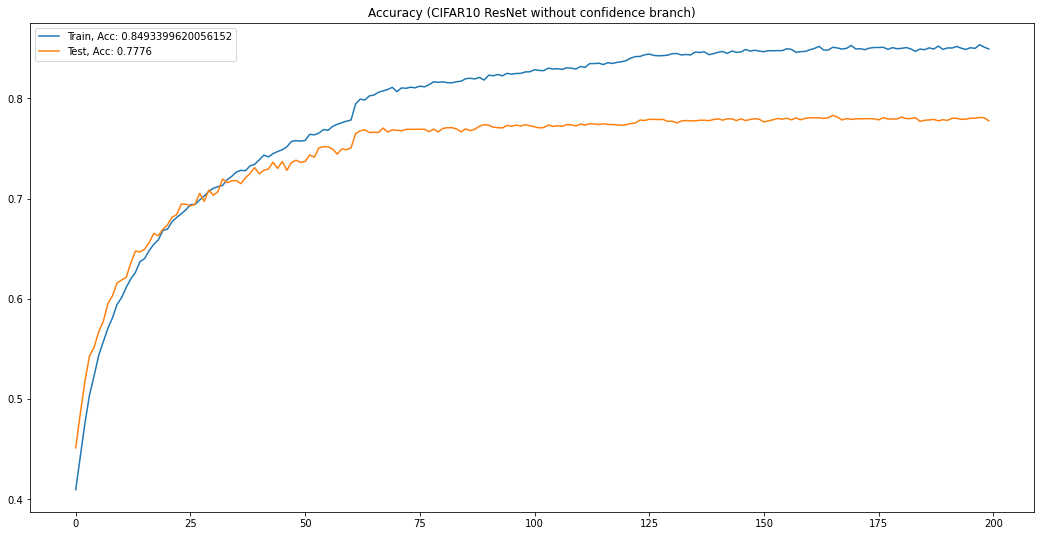

In [92]:
plt.figure(figsize=(18, 9))
plt.plot(np.arange(len(acc_train_baseline)), acc_train_baseline, label=f'Train, Acc: {acc_train_baseline[-1]}')
plt.plot(np.arange(len(acc_test_baseline)), acc_test_baseline, label=f'Test, Acc: {acc_test_baseline[-1]}')
plt.title(f'Accuracy (CIFAR10 ResNet without confidence branch)')
plt.legend()

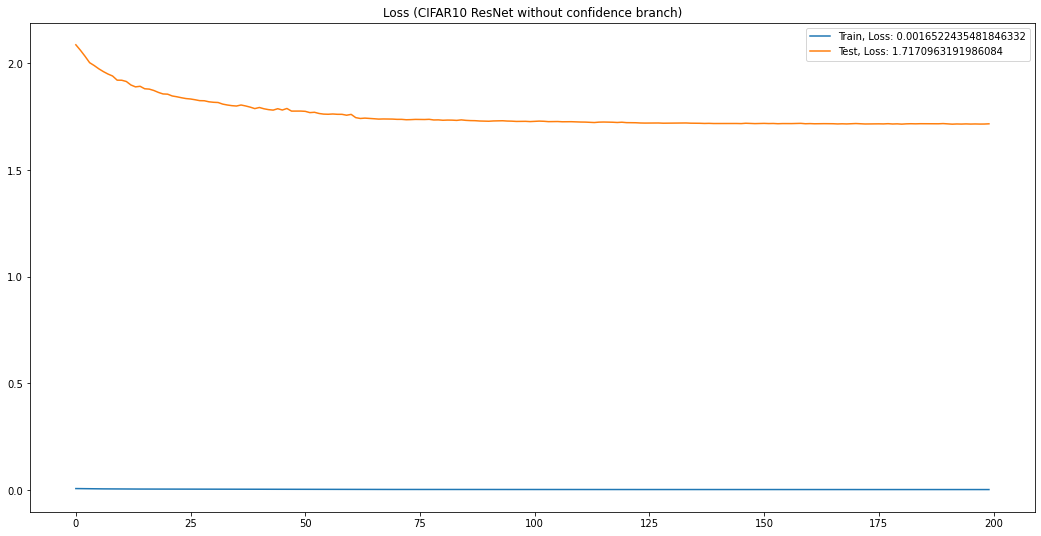

In [93]:
plt.figure(figsize=(18, 9))
plt.plot(np.arange(len(loss_train_baseline)), loss_train_baseline, label=f'Train, Loss: {loss_train_baseline[-1]}')
plt.plot(np.arange(len(loss_test_baseline)), loss_test_baseline, label=f'Test, Loss: {loss_test_baseline[-1]}')
plt.title(f'Loss (CIFAR10 ResNet without confidence branch)')
plt.legend()

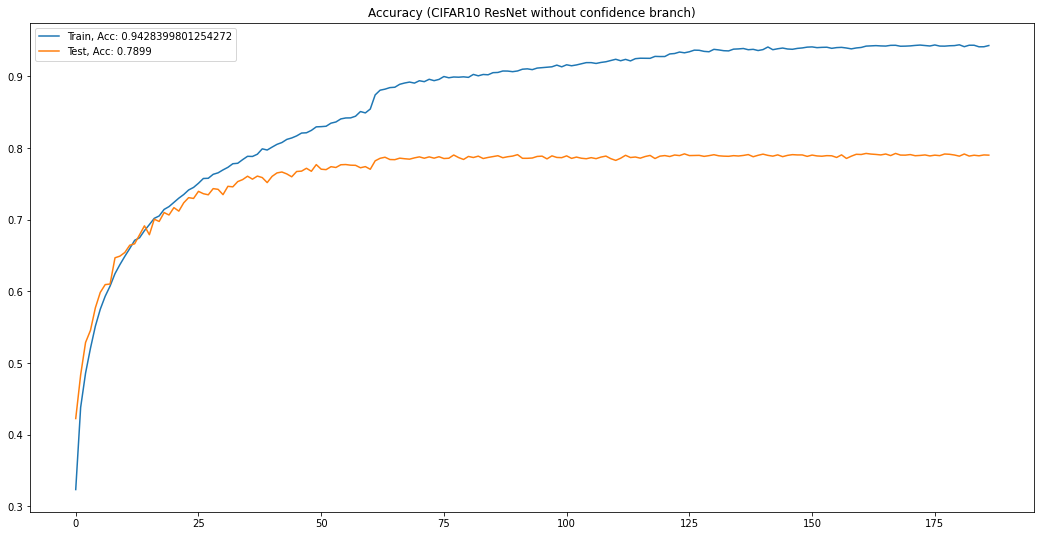

In [98]:
plt.figure(figsize=(18, 9))
plt.plot(np.arange(len(acc_train_cb)), acc_train_cb, label=f'Train, Acc: {acc_train_cb[-1]}')
plt.plot(np.arange(len(acc_test_cb)), acc_test_cb, label=f'Test, Acc: {acc_test_cb[-1]}')
plt.title(f'Accuracy (CIFAR10 ResNet with confidence branch)')
plt.legend()

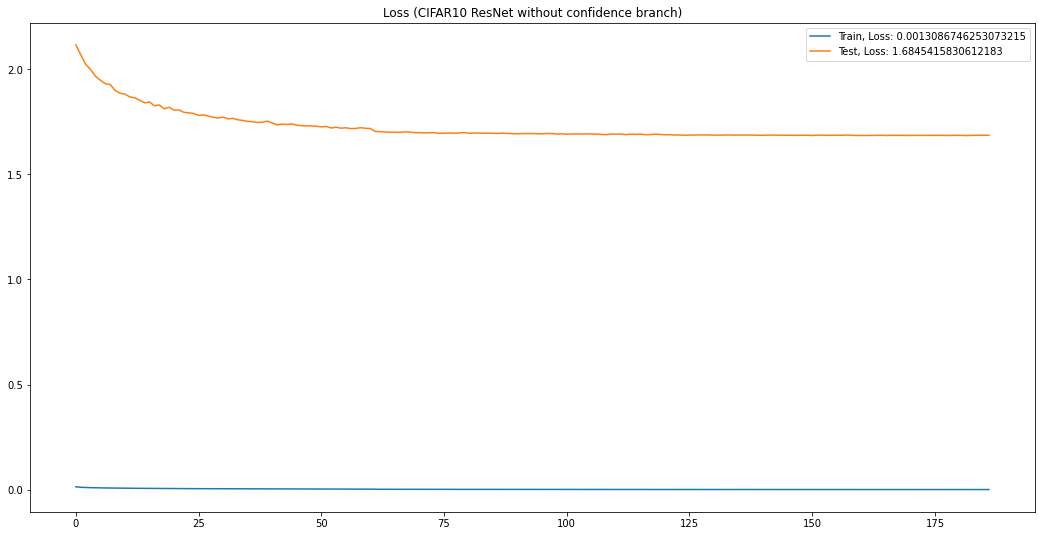

In [99]:
plt.figure(figsize=(18, 9))
plt.plot(np.arange(len(loss_train_cb)), loss_train_cb, label=f'Train, Loss: {loss_train_cb[-1]}')
plt.plot(np.arange(len(loss_test_cb)), loss_test_cb, label=f'Test, Loss: {loss_test_cb[-1]}')
plt.title(f'Loss (CIFAR10 ResNet with confidence branch)')
plt.legend()

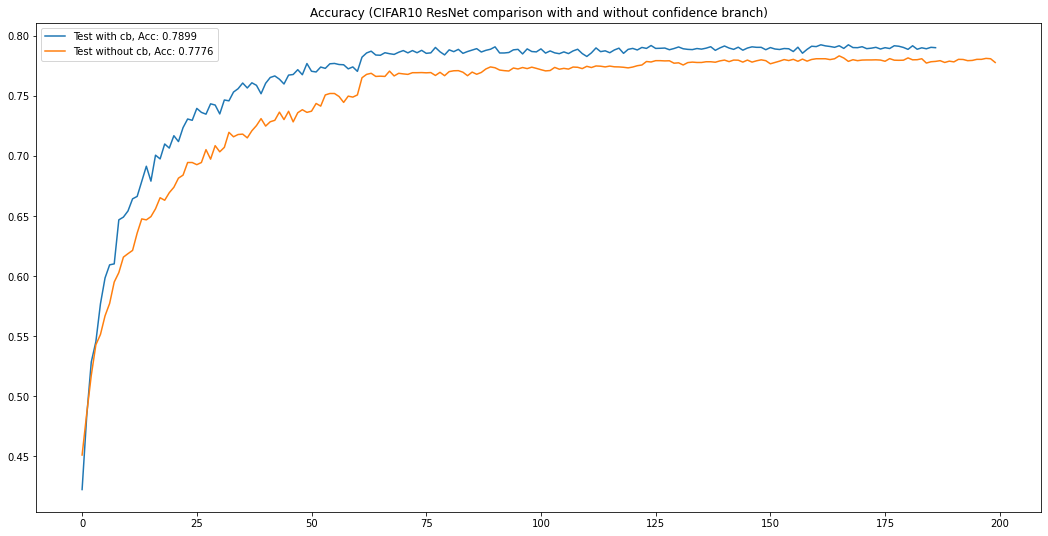

In [100]:
plt.figure(figsize=(18, 9))
plt.plot(np.arange(len(acc_test_cb)), acc_test_cb, label=f'Test with cb, Acc: {acc_test_cb[-1]}')
plt.plot(np.arange(len(acc_test_baseline)), acc_test_baseline, label=f'Test without cb, Acc: {acc_test_baseline[-1]}')
plt.title(f'Accuracy (CIFAR10 ResNet comparison with and without confidence branch)')
plt.legend()

Confidence branch заметно ускоряет обучение, и дает небольшой прирост в точности.